In [1]:
import numpy as np
import pandas as pd
import torch, copy, random, time, cv2, utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchinfo import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset Description

In [3]:
dataset_desc = pd.read_csv('kidneyData.csv', index_col = 0)

In [4]:
dataset_desc.sample(5)

,image_id,path,diag,target,Class
870,Tumor- (443),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
6020,Normal- (4207),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Normal,1,Normal
8989,Cyst- (1314),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12377,Cyst- (697),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
6975,Normal- (892),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Normal,1,Normal


In [5]:
dataset_desc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12446 entries, 0 to 12445
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  12446 non-null  object
 1   path      12446 non-null  object
 2   diag      12446 non-null  object
 3   target    12446 non-null  int64 
 4   Class     12446 non-null  object
dtypes: int64(1), object(4)
memory usage: 583.4+ KB


In [6]:
print("List of dataset features/columns: ")
print(list(dataset_desc.columns))       # List of column names

List of dataset features/columns: 
['image_id', 'path', 'diag', 'target', 'Class']


In [7]:
print("The record number of kidney image dataset", dataset_desc.shape[0])

The record number of kidney image dataset 12446


### Image Examples

There are 4 kidney image examples:
- **Cyst** image
- **Normal** image
- **Stone** image
- **Tumor** image

In [8]:
# Path to the image
image_path_cyst = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (6).jpg"
image_path_norm = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (6).jpg"
image_path_stone = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone/Stone- (6).jpg"
image_path_tumor = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor/Tumor- (6).jpg"


# Load the image
img_cyst = cv2.imread(image_path_cyst, 1)
img_norm = cv2.imread(image_path_norm, 1)
img_stone = cv2.imread(image_path_stone, 1)
img_tumor = cv2.imread(image_path_tumor, 1)

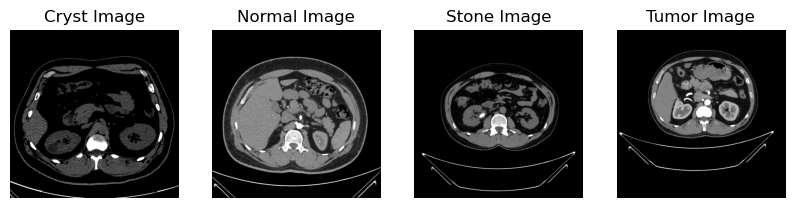

In [9]:
# Display
plt.figure(figsize=(10, 5))

# Cyst Image
plt.subplot(1, 4, 1), plt.title('Cryst Image')
plt.imshow(img_cyst)
plt.axis('off')  # Hide axes for better visualization

# Normal Image
plt.subplot(1, 4, 2), plt.title('Normal Image')
plt.imshow(img_norm)  # Clip and convert noise to uint8
plt.axis('off')

# Stone Image
plt.subplot(1, 4, 3), plt.title('Stone Image')
plt.imshow(img_stone)
plt.axis('off')

# Tumor Image
plt.subplot(1, 4, 4), plt.title('Tumor Image')
plt.imshow(img_tumor)
plt.axis('off')

plt.show()

### Custom Image Dataset

In [10]:
class CT_KidneyDataset(Dataset):
    def __init__(self, data_file, root_dir, num_classes=4, file_format=".jpg", transform=None):
        """
        Args:
            csv_file (str or pd.DataFrame): Path to the csv file with image paths and labels,
                                            or a pandas DataFrame containing the data.
            root_dir (str): Directory containing all images.
            num_classes (int): Number of classes for one-hot encoding.
            file_format (str): File format for the images (default is ".jpg").
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        if isinstance(data_file, str):
            self.data_frame = pd.read_csv(data_file)  # Load from CSV file
        elif isinstance(data_file, pd.DataFrame):
            self.data_frame = data_file  # Use the provided DataFrame directly
        else:
            raise ValueError("csv_file should be a file path (str) or a pandas DataFrame.")
        
        self.root_dir = root_dir
        self.file_format = file_format
        self.transform = transform
        self.num_classes = num_classes

        # Extract file paths and labels
        self.image_paths = (
            self.root_dir 
            + self.data_frame["Class"].astype(str).values 
            + "/" 
            + self.data_frame["image_id"].astype(str).values 
            + self.file_format
        )
        self.labels = self.data_frame['target'].values  # Extract labels

    def __len__(self):
        """Returns the total number of images in the dataset."""
        return len(self.data_frame)

    def __getitem__(self, idx):
        """Loads and returns an image and its one-hot encoded label at the given index."""
        # Get the image path and label
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the image
        image = Image.open(img_path).convert("RGB")  # Convert to RGB

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Convert label to one-hot encoding if num_classes > 1
        one_hot_label = torch.zeros(self.num_classes)
        one_hot_label[label] = 1
        
        return image, one_hot_label

Configure root directory, csv file and torchvision transform class

In [11]:
# Kidney Image Root Directory
root_dir = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/"

# CSV file path
csv_file = "kidneyData.csv"

# Data Transformation for Training dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),                # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=0.5),                  # Randomly flip the image vertically
    transforms.RandomRotation(degrees=30),                 # Random rotation up to ±30 degrees
    transforms.RandomResizedCrop(size=(224, 224),          # Random crop and resize to 224x224
                                 scale=(0.8, 1.0),         # Crop scale between 80% and 100% of the image
                                 ratio=(0.75, 1.33)),      # Aspect ratio variation                   
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust intensity
    transforms.ToTensor(),                                 # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],       # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])        
])

# Data Transformation for Validation dataset
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Data Transformation for Testing dataset
test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),                # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(p=0.5),                  # Randomly flip the image vertically
    transforms.RandomRotation(degrees=30),                 # Random rotation up to ±30 degrees
    transforms.Resize((224, 224)),               
    transforms.ToTensor(),                                 # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],       # Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])        
])

Split into **training dataset** and  **testing dataset**

In [12]:
# Read
csv_df = pd.read_csv(csv_file, index_col = 0)

# Split the dataset
train_df, test_df = train_test_split(csv_df, test_size=0.3, stratify=csv_df['target'], random_state=42)
valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['target'], random_state=42)

In [13]:
print("\nClass distribution in the train set:")
print(train_df['target'].value_counts())

print("\nClass distribution in the valid set:")
print(valid_df['target'].value_counts())

print("\nClass distribution in the test set:")
print(test_df['target'].value_counts())


Class distribution in the train set:
target
1    3554
0    2596
3    1598
2     964
Name: count, dtype: int64

Class distribution in the valid set:
target
1    762
0    556
3    343
2    206
Name: count, dtype: int64

Class distribution in the test set:
target
1    761
0    557
3    342
2    207
Name: count, dtype: int64


Load **Kidney dataset** in Custom Dataset

In [14]:
train_image_data = CT_KidneyDataset(data_file = train_df, root_dir = root_dir, transform = train_transform)
valid_image_data = CT_KidneyDataset(data_file = valid_df, root_dir = root_dir, transform = valid_transform)
test_image_data = CT_KidneyDataset(data_file = test_df, root_dir = root_dir, transform = test_transform)

Display one of the kidney image

In [15]:
def display_tensor_image(tensor_image):
    """
    Display an image from a PyTorch tensor using matplotlib.

    Args:
        tensor_image (torch.Tensor): The image in a PyTorch tensor format (C, H, W).
    """
    # Ensure the tensor is in the right format (C, H, W -> H, W, C)
    image_np = tensor_image.permute(1, 2, 0).numpy()  # Convert from CHW to HWC
    
    # If the tensor values are between [0, 1], convert to [0, 255]
    if image_np.max() <= 1.0:
        image_np = (image_np * 255).astype(np.uint8)
    
    # Display the image using matplotlib
    plt.imshow(image_np)
    plt.axis('off')  # Hide the axes
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


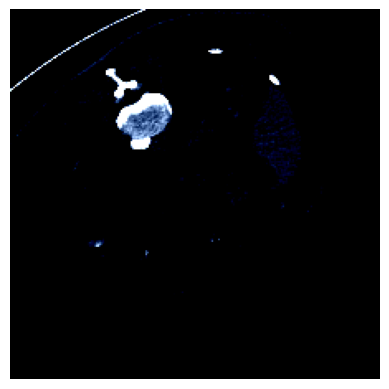

In [16]:
display_tensor_image(train_image_data[200][0])

Create Dataloaders for **Training & Testing** Dataset

In [17]:
# Configure batch size and num of workers
batch_size = 32
num_workers = 0

# Create DataLoader for the training, validation and testing dataset
train_loader = DataLoader(train_image_data, batch_size = batch_size, shuffle=True, num_workers = num_workers)
valid_loader = DataLoader(valid_image_data, batch_size = batch_size, shuffle=False, num_workers = num_workers)
test_loader = DataLoader(test_image_data, batch_size = batch_size, shuffle=False, num_workers = num_workers)

In [18]:
# Number of records (samples) in the training, validation and testing datasets
print("The record number of training dataset:", len(train_image_data))
print("The record number of validation dataset:", len(valid_image_data))
print("The record number of testing dataset:", len(test_image_data))
print()

# Number of batches in the training, validation and testing dataloaders
print("The number of batches in the training dataset:", len(train_loader))
print("The number of batches in the validation dataset:", len(valid_loader))
print("The number of batches in the testing dataset:", len(test_loader))

The record number of training dataset: 8712
The record number of validation dataset: 1867
The record number of testing dataset: 1867

The number of batches in the training dataset: 273
The number of batches in the validation dataset: 59
The number of batches in the testing dataset: 59


### Create Neural Network

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class baseline_CNN_v2(nn.Module):
    def __init__(self, num_classes=4):
        super(baseline_CNN_v2, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # Layer 1
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after conv1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)  # Layer 2
        self.bn2 = nn.BatchNorm2d(32)  # Batch normalization after conv2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer after conv2
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)  # Layer 3
        self.bn3 = nn.BatchNorm2d(64)  # Batch normalization after conv3
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)  # Layer 4
        self.bn4 = nn.BatchNorm2d(64)  # Batch normalization after conv4
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer after conv4

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Layer 5
        self.bn5 = nn.BatchNorm2d(128)  # Batch normalization after conv5|
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)  # Layer 6
        self.bn6 = nn.BatchNorm2d(128)  # Batch normalization after conv6|
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer after conv6

        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)  # Layer 7
        self.bn7 = nn.BatchNorm2d(256)  # Batch normalization after conv7|
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)  # Layer 8
        self.bn8 = nn.BatchNorm2d(256)  # Batch normalization after conv8|
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer after conv8
        
        # Flatten layer
        self.flatten = nn.Flatten()  # Automatically flattens the feature maps
        
        # Fully connected layers with dropout
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)  # Adjust input size based on input image dimensions
        self.dropout1 = nn.Dropout(0.5)  # Dropout after fc1
        
        self.fc2 = nn.Linear(1024, 512)  # Layer 5
        self.dropout2 = nn.Dropout(0.5)  # Dropout after fc2

        self.fc3 = nn.Linear(512, num_classes)  # Layer 6 (output layer)
    
    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        
        # Block 2
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))
        
        # Block 3
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(F.relu(self.bn6(self.conv6(x))))
        
        # Block 4
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool4(F.relu(self.bn8(self.conv8(x))))
        
        # Flatten the feature maps for the fully connected layers
        x = self.flatten(x)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # No activation for the output layer (use softmax in loss function if needed)
        
        return x


In [20]:
cnn_model = baseline_CNN_v2()
cnn_model = cnn_model.to(device)

In [21]:
# Print the summary
summary(cnn_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
baseline_CNN_v2                          [1, 4]                    --
├─Conv2d: 1-1                            [1, 32, 224, 224]         896
├─BatchNorm2d: 1-2                       [1, 32, 224, 224]         64
├─Conv2d: 1-3                            [1, 32, 224, 224]         9,248
├─BatchNorm2d: 1-4                       [1, 32, 224, 224]         64
├─MaxPool2d: 1-5                         [1, 32, 112, 112]         --
├─Conv2d: 1-6                            [1, 64, 112, 112]         18,496
├─BatchNorm2d: 1-7                       [1, 64, 112, 112]         128
├─Conv2d: 1-8                            [1, 64, 112, 112]         36,928
├─BatchNorm2d: 1-9                       [1, 64, 112, 112]         128
├─MaxPool2d: 1-10                        [1, 64, 56, 56]           --
├─Conv2d: 1-11                           [1, 128, 56, 56]          73,856
├─BatchNorm2d: 1-12                      [1, 128, 56, 56]          

### Train Model

In [22]:
def train_model(model, train_loader, test_loader, device = device, learning_rate=0.001, weight_decay=1e-4, num_epochs=10):
    # Initialize lists to store metrics for each epoch
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    model_list = []  # To store model state after each epoch

    # Move model to the specified device
    model = model.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    print("Total Epochs:", num_epochs)

    # Start the overall timer
    overall_start_time = time.time()

    for epoch in range(num_epochs):
        # Start timer for the current epoch
        epoch_start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)  # Raw logits, no softmax
            loss = criterion(outputs, labels.argmax(dim=1))  # Convert one-hot labels to class indices

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item() * inputs.size(0)

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            correct_train += (predicted == labels.argmax(dim=1)).sum().item()  # Convert one-hot labels
            total_train += labels.size(0)

        # Calculate average training loss and accuracy
        epoch_train_loss = running_loss / total_train
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        # Evaluation phase
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  # Raw logits
                loss = criterion(outputs, labels.argmax(dim=1))  # Convert one-hot labels to class indices

                # Accumulate testing loss
                running_test_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_test += (predicted == labels.argmax(dim=1)).sum().item()  # Convert one-hot labels
                total_test += labels.size(0)

        # Calculate average validation loss and accuracy
        epoch_test_loss = running_test_loss / total_test
        epoch_test_accuracy = correct_test / total_test
        test_losses.append(epoch_test_loss)
        test_accuracies.append(epoch_test_accuracy)

        # Store a copy of the model's state after this epoch
        model_list.append(copy.deepcopy(model.state_dict()))

        # Stop timer for the current epoch
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Format duration for current epoch
        hours = int(epoch_duration // 3600)
        minutes = int((epoch_duration % 3600) // 60)
        seconds = int(epoch_duration % 60)
        epoch_duration_str = f"{hours:02}:{minutes:02}:{seconds:02}"

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy * 100:.2f}%, "
            f"Valid Loss: {epoch_test_loss:.4f}, Valid Acc: {epoch_test_accuracy * 100:.2f}% "
            f"(Duration: {epoch_duration_str})")

    # Stop the overall timer
    overall_end_time = time.time()
    total_duration = overall_end_time - overall_start_time

    # Format total training duration
    hours = int(total_duration // 3600)
    minutes = int((total_duration % 3600) // 60)
    seconds = int(total_duration % 60)
    total_duration_str = f"{hours:02}:{minutes:02}:{seconds:02}"

    print("Model Training Completed!")
    print(f"[Total Training Time] {total_duration_str}")

    results = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'model_list': model_list
    }

    return results

In [23]:
results = train_model(cnn_model, train_loader, valid_loader, learning_rate = 0.001, weight_decay=0.001, num_epochs = 20)

Total Epochs: 20
Epoch [1/20], Train Loss: 1.5680, Train Acc: 56.43%, Valid Loss: 0.9399, Valid Acc: 61.60% (Duration: 00:03:13)
Epoch [2/20], Train Loss: 0.8941, Train Acc: 66.48%, Valid Loss: 0.9949, Valid Acc: 64.76% (Duration: 00:02:06)
Epoch [3/20], Train Loss: 0.8469, Train Acc: 67.32%, Valid Loss: 0.6946, Valid Acc: 72.31% (Duration: 00:02:03)
Epoch [4/20], Train Loss: 0.7734, Train Acc: 69.23%, Valid Loss: 2.5239, Valid Acc: 35.94% (Duration: 00:02:03)
Epoch [5/20], Train Loss: 0.7254, Train Acc: 70.97%, Valid Loss: 0.6044, Valid Acc: 70.76% (Duration: 00:02:05)
Epoch [6/20], Train Loss: 0.6760, Train Acc: 72.66%, Valid Loss: 0.6950, Valid Acc: 73.75% (Duration: 00:02:05)
Epoch [7/20], Train Loss: 0.6550, Train Acc: 72.95%, Valid Loss: 0.5613, Valid Acc: 76.97% (Duration: 00:02:05)
Epoch [8/20], Train Loss: 0.6363, Train Acc: 73.94%, Valid Loss: 0.7018, Valid Acc: 71.51% (Duration: 00:02:05)
Epoch [9/20], Train Loss: 0.6099, Train Acc: 74.78%, Valid Loss: 1.3223, Valid Acc: 56.

### Result Plotting

In [23]:
def plot_training_results(results):
    # Extract metrics from the results dictionary
    train_losses = results['train_losses']
    test_losses = results['test_losses']
    train_accuracies = results['train_accuracies']
    test_accuracies = results['test_accuracies']
    
    epochs = range(1, len(train_losses) + 1)

    # Plot training vs testing losses
    plt.figure(figsize=(12, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in train_accuracies], label='Training Accuracy')
    plt.plot(epochs, [acc * 100 for acc in test_accuracies], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

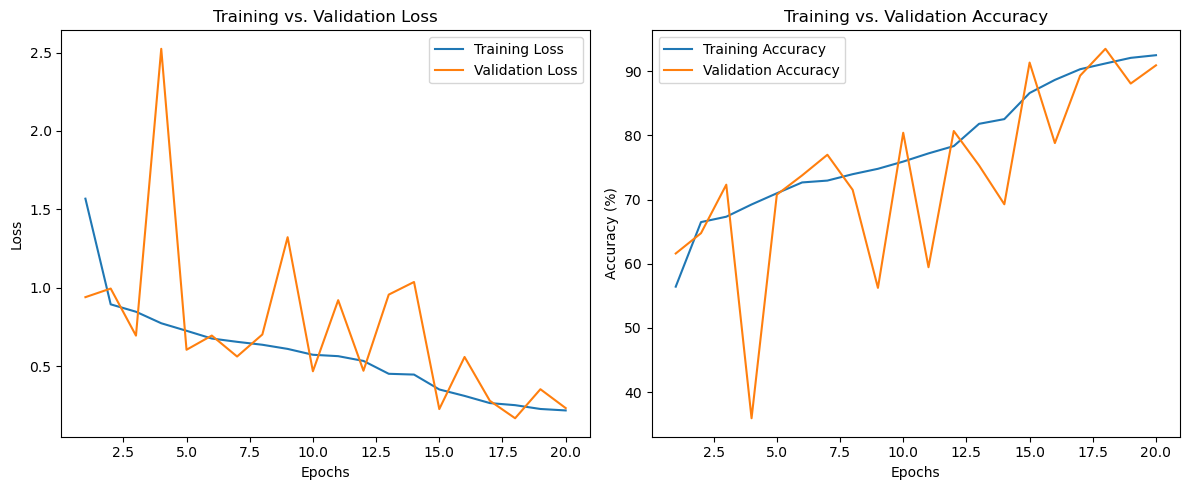

In [25]:
plot_training_results(results)

### Save and Load Model

In [24]:
def save_model(model, filepath):
    """
    Save the PyTorch model to the specified file path.

    Args:
    - model (torch.nn.Module): The model to save.
    - filepath (str): The file path where the model will be saved.
    """
    # Save the model's state dictionary (weights)
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

In [25]:
def load_model(model_class, filepath, device="cpu", model_args=None):
    """
    Load a PyTorch model from the specified file path.

    Args:
    - model_class (torch.nn.Module): The class of the model to load.
    - filepath (str): The file path from which to load the model.
    - device (str): The device on which to load the model ("cpu" or "cuda").
    - model_args (dict, optional): Arguments to pass to the model class constructor.

    Returns:
    - model (torch.nn.Module): The loaded model with the saved weights.
    """
    if model_args is None:
        model_args = dict()  # Safely create a new dictionary here

    # Initialize the model with additional arguments
    model = model_class(**model_args)

    # Load the model weights into the initialized model
    model.load_state_dict(torch.load(filepath, map_location=device))
    model.to(device)  # Move the model to the desired device
    model.eval()  # Set the model to evaluation mode
    
    print(f"Model loaded from {filepath}")
    
    return model

In [28]:
save_model(cnn_model, "./model/baseline_model_v2.pth")

Model saved to ./model/baseline_model_v2.pth


In [29]:
loaded_model = load_model(baseline_CNN_v2, "./model/baseline_model_v2.pth", device = device)

C:\Users\WINx11\AppData\Local\Temp\ipykernel_8640\775768731.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath, map_location=devi

Model loaded from ./model/baseline_model_v2.pth


### Predict Labels

In [26]:
kidney_labels = [
    "Cyst",
    "Normal",
    "Stone",
    "Tumor"
]

In [27]:
def predicted_label(model, image_path, transform=None, labels=None, device='cpu', show_probabilities=False):
    """
    Predict the label of an image using a CNN model.

    Parameters:
        model (torch.nn.Module): The trained CNN model.
        image_path (str): The path to the image to predict.
        transform (torchvision.transforms.Compose, optional): Custom transformation to apply to the image.
        labels (list of str, optional): List of class labels to map the output index to class names.
        device (str, optional): The device to use for computation ('cpu' or 'cuda').
        show_probabilities (bool, optional): Whether to print the probabilities of each class as percentages.

    Returns:
        str or int: The predicted class label (if `labels` is provided) or the predicted class index.
    """
    
    # Set the model to evaluation mode
    model.eval()
    
    # Default transform if none is provided
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to the input size expected by the model
            transforms.ToTensor(),          # Convert to tensor
            transforms.Normalize(          # Normalize using the mean and std used during training
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            ),
        ])
    
    # Load and preprocess the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Move the image tensor to the same device as the model
    image = image.to(device)
    
    # Forward pass through the model
    with torch.no_grad():  # Disable gradient computation for inference
        output = model(image)
    
    # Get the probabilities using softmax
    probabilities = F.softmax(output, dim=1)
    
    # Get the predicted class (index of the max value in the output)
    _, predicted_idx = torch.max(probabilities, 1)
    
    # If show_probabilities is True, print the probabilities for each class
    if show_probabilities:
        print("Class Probabilities:")
        if labels:
            for idx, prob in enumerate(probabilities.squeeze().tolist()):
                print(f"{labels[idx]}: {prob * 100:.2f}%")
        else:
            for idx, prob in enumerate(probabilities.squeeze().tolist()):
                print(f"Class {idx}: {prob * 100:.2f}%")
    
    # If labels are provided, return the label name instead of index
    if labels:
        predicted_label = labels[predicted_idx.item()]
        return predicted_label
    else:
        return predicted_idx.item()  # Convert the tensor to a Python number

In [32]:
kidney_cyst_path  = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (200).jpg"
predicted_label(loaded_model, kidney_cyst_path, transform=test_transform, labels=kidney_labels, device=device, show_probabilities=True)

Class Probabilities:
Cyst: 95.68%
Normal: 0.49%
Stone: 3.18%
Tumor: 0.64%


'Cyst'

In [33]:
kidney_tumor_path  = "./CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal/Normal- (3).jpg"
predicted_label(loaded_model, kidney_tumor_path, transform=test_transform, labels=kidney_labels, device=device, show_probabilities=True)

Class Probabilities:
Cyst: 0.00%
Normal: 94.74%
Stone: 5.24%
Tumor: 0.02%


'Normal'

### Confusion Matrix

In [28]:
def plot_confusion_matrix_and_roc_auc(model, dataloader, labels, model_name, device='cpu', normalize=False):
    """
    Computes and plots the confusion matrix and ROC AUC curve for a model on a given dataset (dataloader).

    Parameters:
        model (torch.nn.Module): The trained model.
        dataloader (torch.utils.data.DataLoader): The dataloader containing the test data.
        labels (list): List of class labels.
        model_name (str): Name of the model to display in the titles.
        device (str): The device to use ('cpu' or 'cuda').
        normalize (bool): If True, normalize the confusion matrix by dividing each row by the sum of that row.
    """
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    y_probs = []  # Store probabilities for ROC AUC

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            # For multiclass classification, use argmax to get the predicted class
            _, predicted = torch.max(outputs, 1)  # Get the predicted class label (argmax)
            y_probs.extend(outputs.softmax(dim=1).cpu().numpy())  # Get probabilities for ROC AUC

            # If targets are one-hot encoded, convert them to class indices using argmax
            targets = torch.argmax(targets, 1)  # Convert one-hot to class labels
            
            y_true.extend(targets.cpu().numpy())  # True labels
            y_pred.extend(predicted.cpu().numpy())  # Predicted labels
    
    # Convert both y_true and y_pred to 1D arrays (flatten them)
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels)))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row

    # Plot the confusion matrix and ROC AUC curve
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Subplot 1: Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, cbar=False, ax=axes[0], annot_kws={"size": 16})
    axes[0].set_title(f'Confusion Matrix ({model_name})', fontsize=16)
    axes[0].set_xlabel('Predicted Labels', fontsize=14)
    axes[0].set_ylabel('True Labels', fontsize=14)
    
    # Subplot 2: ROC AUC Curve
    y_probs = np.array(y_probs)
    n_classes = len(labels)
    fpr = {}
    tpr = {}
    roc_auc = {}
    
    # One-vs-all ROC curves for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve using one-vs-rest binary format
    y_true_binary = label_binarize(y_true, classes=np.arange(n_classes))
    fpr["macro"], tpr["macro"], _ = roc_curve(y_true_binary.ravel(), y_probs.ravel())
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot ROC AUC curves
    axes[1].plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})', linestyle='--', color='blue')
    for i in range(n_classes):
        axes[1].plot(fpr[i], tpr[i], label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})')
    
    axes[1].plot([0, 1], [0, 1], 'k--', lw=1)  # Diagonal line
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_title(f'ROC AUC Curve ({model_name})', fontsize=16)
    axes[1].set_xlabel('False Positive Rate', fontsize=14)
    axes[1].set_ylabel('True Positive Rate', fontsize=14)
    axes[1].legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

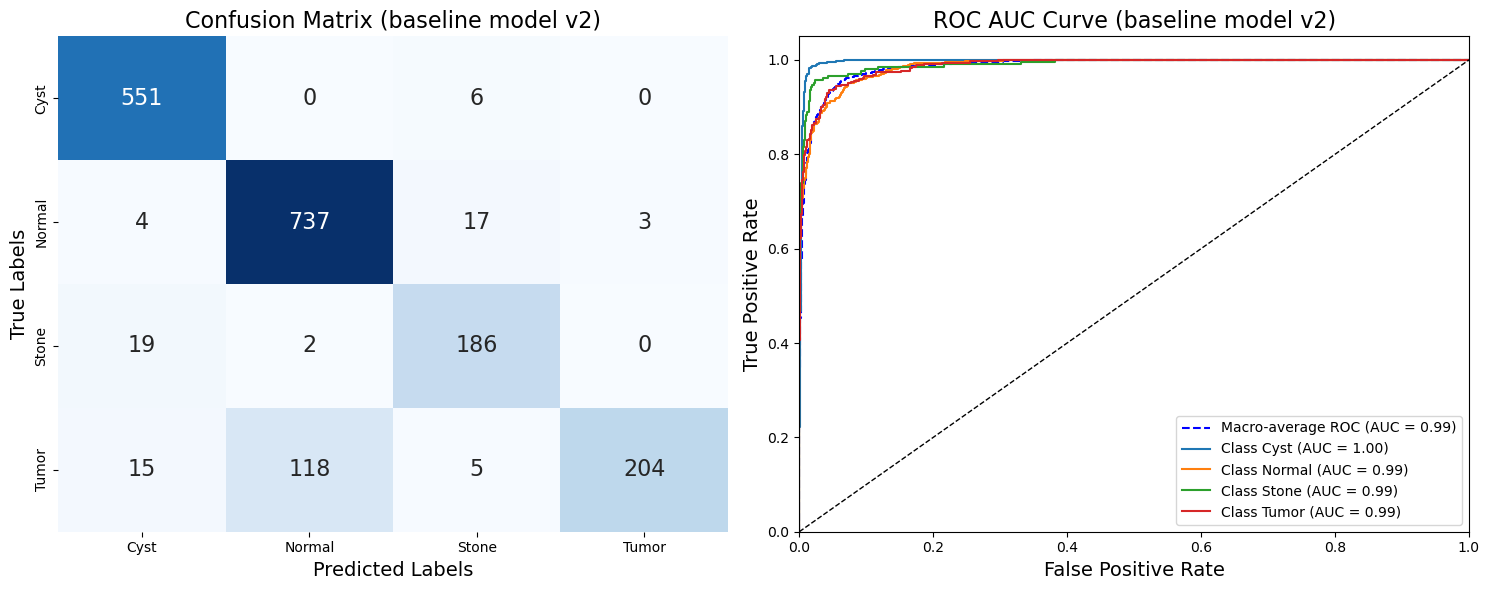

In [35]:
# Call the function to plot the confusion matrix
plot_confusion_matrix_and_roc_auc(loaded_model, test_loader, kidney_labels, "baseline model v2", device=device)

Plot confusion matrix and roc curve for previous baseline model

In [29]:
loaded_baseline_model = load_model(utils.baseline_CNN, "./model/baseline_model.pth", device = device)

C:\Users\WINx11\AppData\Local\Temp\ipykernel_19768\775768731.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath, map_location=dev

Model loaded from ./model/baseline_model.pth


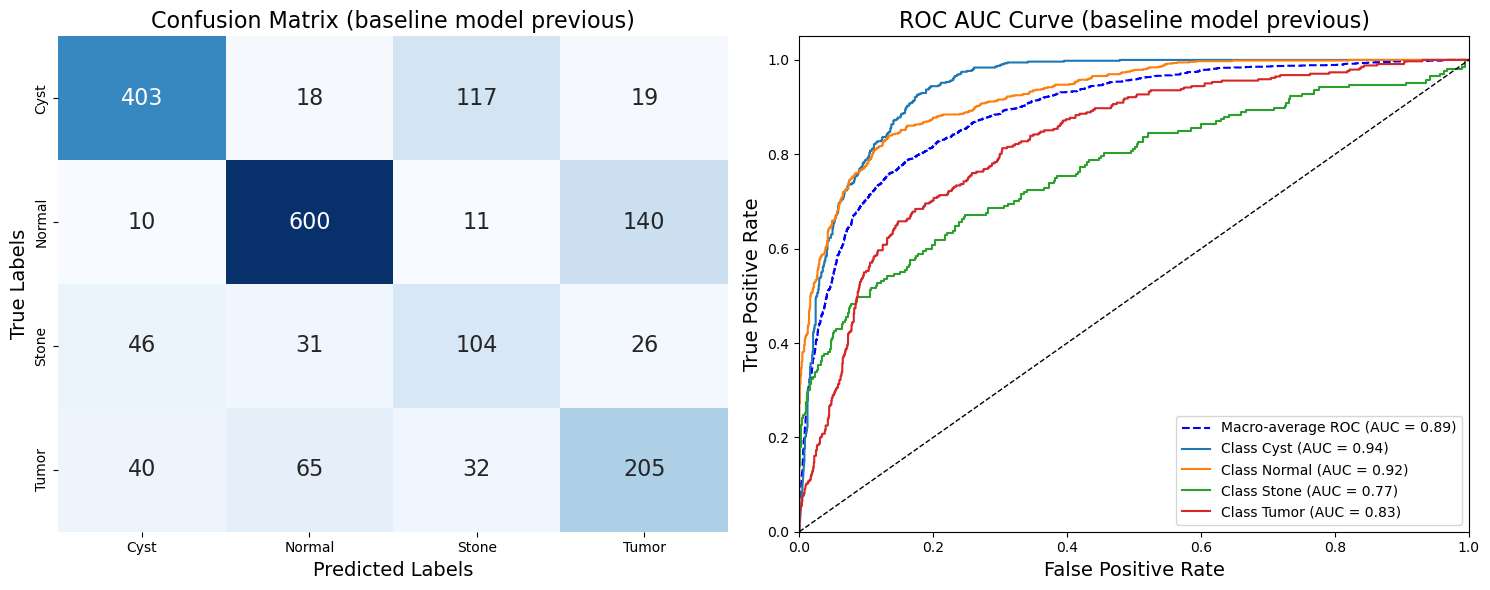

In [30]:
# Call the function to plot the confusion matrix
plot_confusion_matrix_and_roc_auc(loaded_baseline_model, test_loader, kidney_labels, "baseline model previous", device=device)

### Pretrained Model

#### 1. ResNet50

In [38]:
resnet_50 = models.resnet50(pretrained=True)

resnet_50.fc = nn.Sequential(
    nn.Linear(resnet_50.fc.in_features, 1024),  # Reduce to 512 features
    nn.ReLU(),                     # Add ReLU activation
    nn.Dropout(0.5),               # Add dropout for regularization
    nn.Linear(1024, 512),              # Map to 4 output classes
    nn.ReLU(),                     
    nn.Dropout(0.5),               
    nn.Linear(512, 4)              
)

c:\Users\WINx11\anaconda3\envs\ml_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\WINx11\anaconda3\envs\ml_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
summary(resnet_50, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

In [40]:
resnet50_results = train_model(resnet_50, train_loader, valid_loader, learning_rate = 0.001, weight_decay=0.001, num_epochs = 20)

Total Epochs: 20
Epoch [1/20], Train Loss: 0.7318, Train Acc: 71.36%, Valid Loss: 0.6233, Valid Acc: 75.52% (Duration: 00:07:50)
Epoch [2/20], Train Loss: 0.5980, Train Acc: 76.27%, Valid Loss: 0.5519, Valid Acc: 78.68% (Duration: 00:08:07)
Epoch [3/20], Train Loss: 0.5576, Train Acc: 77.66%, Valid Loss: 0.5949, Valid Acc: 74.72% (Duration: 00:09:44)
Epoch [4/20], Train Loss: 0.5408, Train Acc: 78.57%, Valid Loss: 0.6944, Valid Acc: 70.54% (Duration: 00:10:15)
Epoch [5/20], Train Loss: 0.5083, Train Acc: 79.75%, Valid Loss: 1.2328, Valid Acc: 55.54% (Duration: 00:10:04)
Epoch [6/20], Train Loss: 0.5261, Train Acc: 78.73%, Valid Loss: 0.4480, Valid Acc: 80.82% (Duration: 00:09:30)
Epoch [7/20], Train Loss: 0.4777, Train Acc: 80.60%, Valid Loss: 0.8232, Valid Acc: 63.69% (Duration: 00:10:16)
Epoch [8/20], Train Loss: 0.4610, Train Acc: 81.39%, Valid Loss: 1.6553, Valid Acc: 68.18% (Duration: 00:10:21)
Epoch [9/20], Train Loss: 0.4449, Train Acc: 82.31%, Valid Loss: 0.4893, Valid Acc: 81.

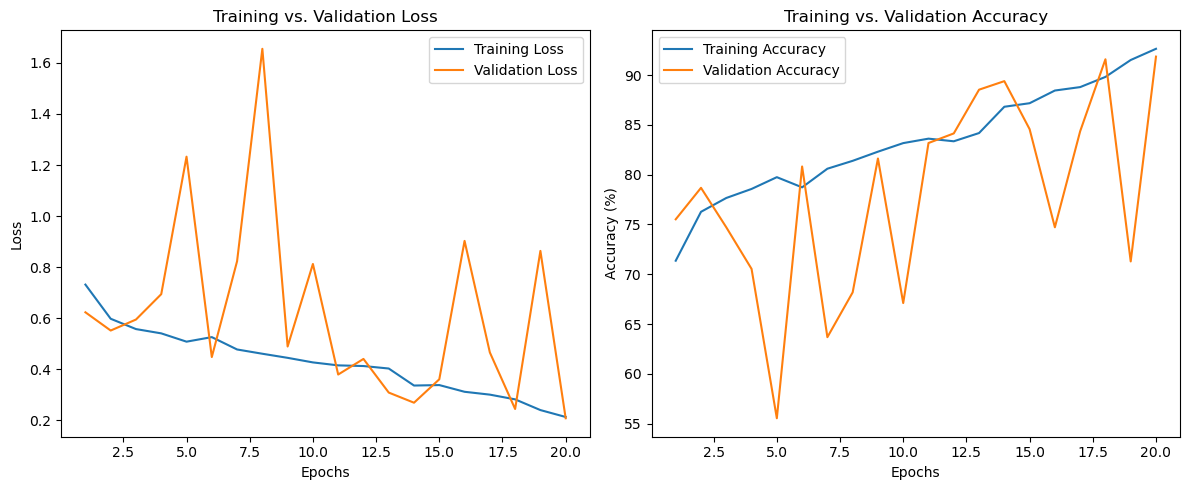

In [41]:
plot_training_results(resnet50_results)

In [42]:
# Save the model to a file
save_model(resnet_50, "./model/resnet50_model.pth")

Model saved to ./model/resnet50_model.pth


In [43]:
# Define a function to create the ResNet-50 with the modified fc layers
def create_resnet50_with_fc(pretrained=False, num_classes=4):
    model = models.resnet50(pretrained=pretrained)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 1024),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

In [44]:
# Load the model using the load_model function
loaded_resnet_50 = load_model(
    model_class=create_resnet50_with_fc,  # Function to create the ResNet-50 with modified fc layers
    filepath="./model/resnet50_model.pth",     # Path to the saved model weights
    device=device,  # Set the device
    model_args={"pretrained": False}  # Arguments for model creation
)

c:\Users\WINx11\anaconda3\envs\ml_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\WINx11\AppData\Local\Temp\ipykernel_8640\775768731.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `to

Model loaded from ./model/resnet50_model.pth


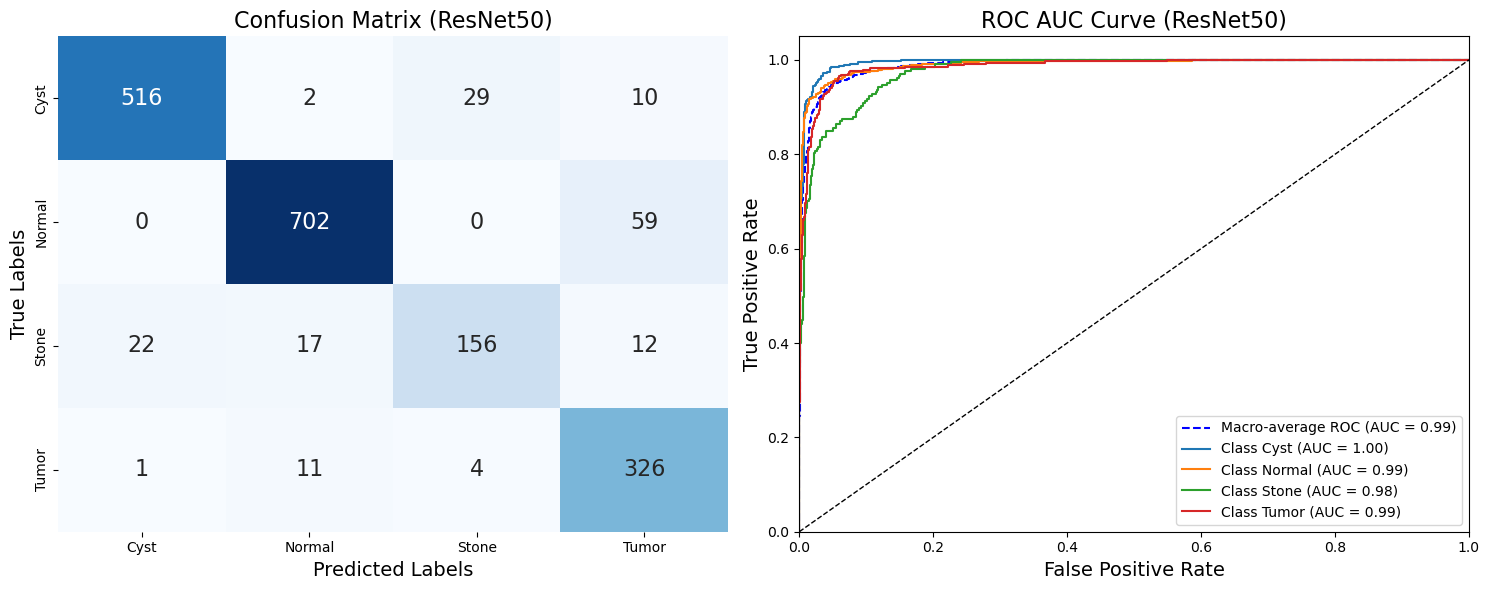

In [45]:
# Call the function to plot the confusion matrix
plot_confusion_matrix_and_roc_auc(loaded_resnet_50, test_loader, kidney_labels, "ResNet50", device=device)

#### 2. MobileNet

In [46]:
mobilenet_v3 = models.mobilenet_v3_large(pretrained=True)

mobilenet_v3.classifier = nn.Sequential(
    nn.Linear(mobilenet_v3.classifier[0].in_features, 1024),  # Add a hidden layer with 512 units
    nn.ReLU(),                     # ReLU activation
    nn.Dropout(0.5),               # Dropout for regularization
    nn.Linear(1024, 512),             # Output layer for 4 classes
    nn.ReLU(),                     # ReLU activation
    nn.Dropout(0.5),               # Dropout for regularization
    nn.Linear(512, 4)              # Output layer for 4 classes
)

c:\Users\WINx11\anaconda3\envs\ml_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\WINx11\anaconda3\envs\ml_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
summary(mobilenet_v3, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV3                                        [1, 4]                    --
├─Sequential: 1-1                                  [1, 960, 7, 7]            --
│    └─Conv2dNormActivation: 2-1                   [1, 16, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 16, 112, 112]         432
│    │    └─BatchNorm2d: 3-2                       [1, 16, 112, 112]         32
│    │    └─Hardswish: 3-3                         [1, 16, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         464
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           3,440
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6   

In [48]:
mobilenet_results = train_model(mobilenet_v3, train_loader, valid_loader, learning_rate = 0.001, num_epochs = 20)

Total Epochs: 20
Epoch [1/20], Train Loss: 0.3438, Train Acc: 87.98%, Valid Loss: 0.8094, Valid Acc: 75.63% (Duration: 00:04:32)
Epoch [2/20], Train Loss: 0.1478, Train Acc: 95.29%, Valid Loss: 0.1472, Valid Acc: 95.02% (Duration: 00:03:57)
Epoch [3/20], Train Loss: 0.0944, Train Acc: 97.18%, Valid Loss: 0.2410, Valid Acc: 92.61% (Duration: 00:03:58)
Epoch [4/20], Train Loss: 0.1069, Train Acc: 96.88%, Valid Loss: 0.0725, Valid Acc: 97.70% (Duration: 00:03:51)
Epoch [5/20], Train Loss: 0.0818, Train Acc: 97.68%, Valid Loss: 0.0442, Valid Acc: 98.55% (Duration: 00:03:56)
Epoch [6/20], Train Loss: 0.0814, Train Acc: 97.62%, Valid Loss: 0.3474, Valid Acc: 89.82% (Duration: 00:03:54)
Epoch [7/20], Train Loss: 0.0643, Train Acc: 98.15%, Valid Loss: 0.1264, Valid Acc: 95.88% (Duration: 00:03:50)
Epoch [8/20], Train Loss: 0.0377, Train Acc: 98.96%, Valid Loss: 0.0915, Valid Acc: 96.04% (Duration: 00:03:44)
Epoch [9/20], Train Loss: 0.0586, Train Acc: 98.22%, Valid Loss: 0.0950, Valid Acc: 96.

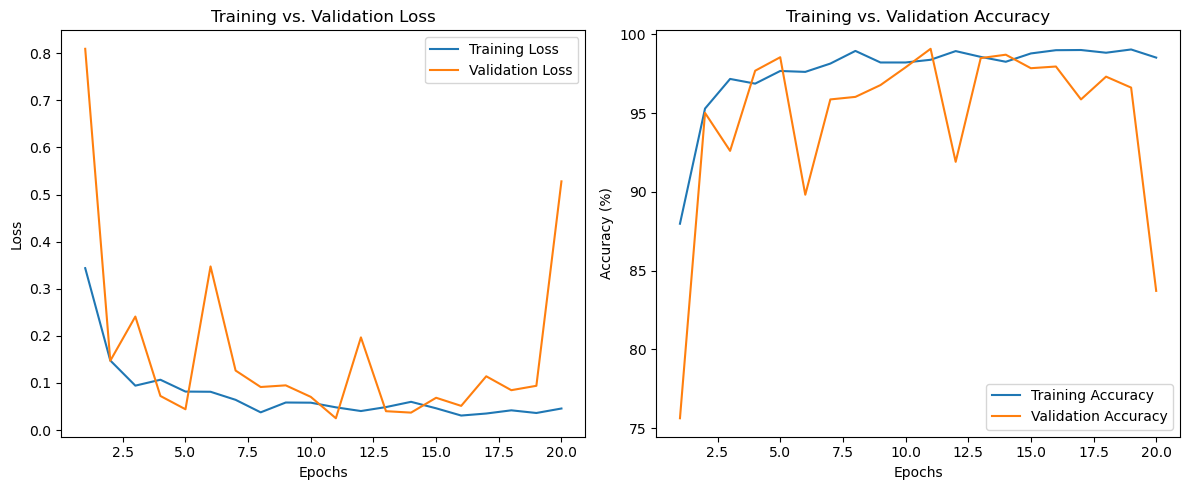

In [49]:
plot_training_results(mobilenet_results)

In [50]:
# Save the model to a file
save_model(mobilenet_v3, "./model/mobilenetv3_model.pth")

Model saved to ./model/mobilenetv3_model.pth


In [51]:
# Define a function to create the ResNet-50 with the modified fc layers
def create_mobilenetv3_with_fc(pretrained=False, num_classes=4):
    model = models.mobilenet_v3_large(pretrained=pretrained)
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[0].in_features, 1024),  # Add a hidden layer with 512 units
        nn.ReLU(),                     # ReLU activation
        nn.Dropout(0.5),               # Dropout for regularization
        nn.Linear(1024, 512),             # Output layer for 4 classes
        nn.ReLU(),                     # ReLU activation
        nn.Dropout(0.5),               # Dropout for regularization
        nn.Linear(512, num_classes)              # Output layer for 4 classes
    )
    return model

In [52]:
# Load the model using the load_model function
loaded_mobilenet_v3 = load_model(
    model_class=create_mobilenetv3_with_fc,  # Function to create the ResNet-50 with modified fc layers
    filepath="./model/mobilenetv3_model.pth",     # Path to the saved model weights
    device=device,  # Set the device
    model_args={"pretrained": False}  # Arguments for model creation
)

c:\Users\WINx11\anaconda3\envs\ml_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\WINx11\AppData\Local\Temp\ipykernel_8640\775768731.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `to

Model loaded from ./model/mobilenetv3_model.pth


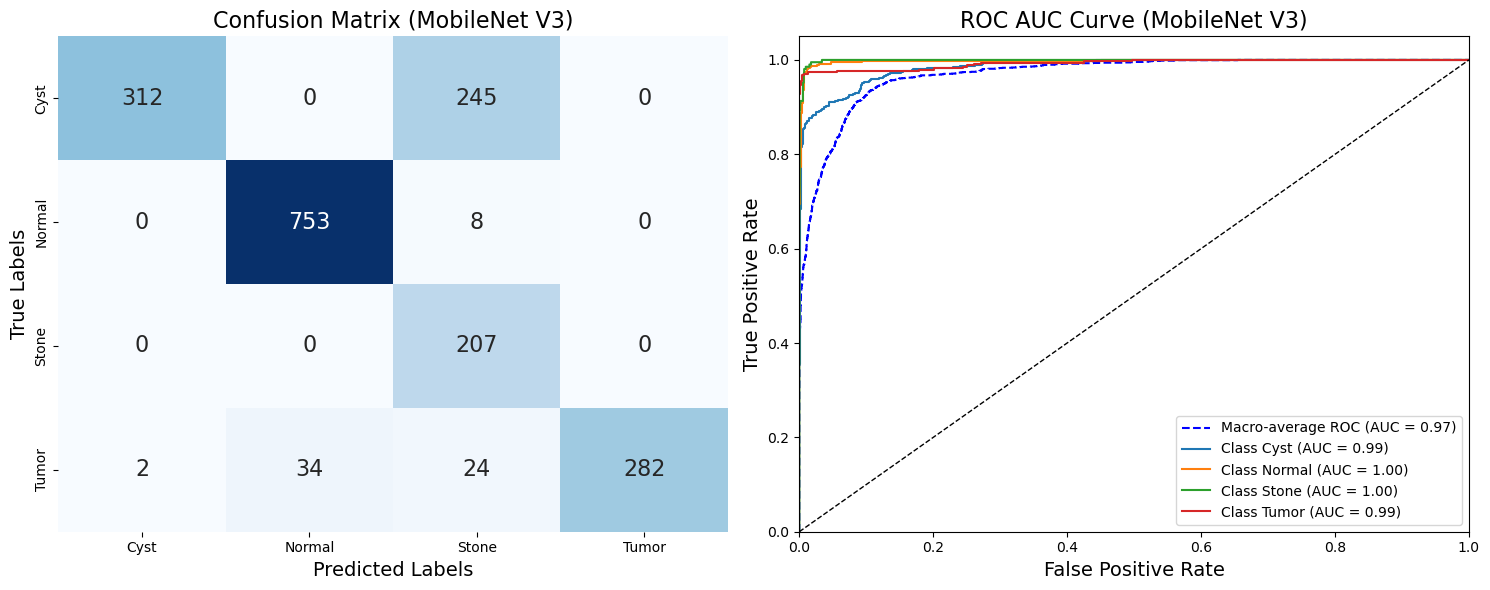

In [53]:
# Call the function to plot the confusion matrix
plot_confusion_matrix_and_roc_auc(loaded_mobilenet_v3, test_loader, kidney_labels, "MobileNet V3", device=device)